In [ ]:
# Toy experiment: optimizing per-trajectory end-frame orientations to align linear demos
# - We generate N straight-line trajectories with different headings from a common start
# - Each trajectory has the same number of steps (alignment solved by construction)
# - Each demo is "represented" in its own end-frame: translate by end-point, then rotate by -theta_i
# - We optimize theta_i to minimize across-demo variance of the represented trajectories
#   with an L2 regularizer that keeps frames near a nominal orientation (0 rad).
#

import math
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple

CONFIG = {
    "seed": 0,
    "num_demos": 8,            # N trajectories
    "num_steps": 40,           # T steps per trajectory
    "step_size": 0.1,          # distance per step
    "angles_deg": None,        # None -> evenly spaced on [-60, 60] deg; or provide a list of degrees
    "lambda_reg": 0.05,        # regularization weight on frame rotation
    "num_iters": 400,          # gradient descent iterations
    "lr": 0.2,                 # learning rate for orientations
}

rng = np.random.default_rng(CONFIG["seed"])



In [ ]:
def make_linear_trajectories(
    N: int, T: int, step: float, angles_deg: np.ndarray | None
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Returns:
      trajs: [N, T, 2] absolute positions (x,y)
      headings: [N] radians (ground-truth forward direction)
    """
    if angles_deg is None:
        # Spread around 0 for visibility
        angles_deg = np.linspace(-60, 60, N)
    else:
        assert len(angles_deg) == N
        angles_deg = np.asarray(angles_deg, dtype=float)
    headings = np.deg2rad(angles_deg)
    # Common start
    start = np.array([0.0, 0.0], dtype=np.float64)
    # Build straight lines
    trajs = []
    for th in headings:
        direction = np.array([math.cos(th), math.sin(th)], dtype=np.float64)
        points = [start]
        for t in range(1, T):
            points.append(start + t * step * direction)
        trajs.append(np.stack(points, axis=0))
    trajs = np.stack(trajs, axis=0)  # [N, T, 2]
    return trajs, headings

def represent_in_end_frame(trajs: torch.Tensor, thetas: torch.Tensor) -> torch.Tensor:
    """
    Translate each trajectory by its endpoint and rotate by -theta_i.
    Args:
      trajs: [N, T, 2] tensor
      thetas: [N] tensor, orientation of each end-frame
    Returns:
      reps: [N, T, 2] represented coordinates
    """
    N, T, _ = trajs.shape
    end_pts = trajs[:, -1, :]                                # [N, 2]
    centered = trajs - end_pts[:, None, :]                   # [N, T, 2]
    c, s = torch.cos(-thetas), torch.sin(-thetas)            # rotate by -theta
    R = torch.stack([torch.stack([c, -s], dim=-1),
                     torch.stack([s,  c], dim=-1)], dim=-2)  # [N, 2, 2]
    reps = torch.einsum("nij,ntj->nti", R, centered)         # [N, T, 2]
    return reps

def alignment_variance_loss(reps: torch.Tensor) -> torch.Tensor:
    """
    Across-demo variance at each time step and coordinate.
    """
    mean = reps.mean(dim=0, keepdim=True)      # [1, T, 2]
    var = ((reps - mean) ** 2).mean()          # scalar: mean over N,T,2
    return var

In [4]:
# ------------------ DATA ------------------
N = CONFIG["num_demos"]
T = CONFIG["num_steps"]
step = CONFIG["step_size"]
angles_deg = CONFIG["angles_deg"]
lambda_reg = CONFIG["lambda_reg"]
num_iters = CONFIG["num_iters"]
lr = CONFIG["lr"]

trajs_np, gt_headings = make_linear_trajectories(N, T, step, angles_deg)
trajs = torch.tensor(trajs_np, dtype=torch.float64)


# Initial frames: all with the same nominal orientation (0 rad)
thetas = torch.zeros(N, dtype=torch.float64, requires_grad=True)

opt = torch.optim.SGD([thetas], lr=lr, momentum=0.0)

history = {"iter": [], "loss": [], "var": [], "reg": []}

for it in range(num_iters):
    opt.zero_grad()
    reps = represent_in_end_frame(trajs, thetas)                 # [N, T, 2]
    var_loss = alignment_variance_loss(reps)
    reg_loss = lambda_reg * (thetas ** 2).mean()
    loss = var_loss + reg_loss
    loss.backward()
    opt.step()

    history["iter"].append(it)
    history["loss"].append(loss.item())
    history["var"].append(var_loss.item())
    history["reg"].append(reg_loss.item())



/home/albi/miniconda3/envs/mujoco_cloth_sim/lib/python3.12/site-packages/torch/autograd/graph.py:824: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


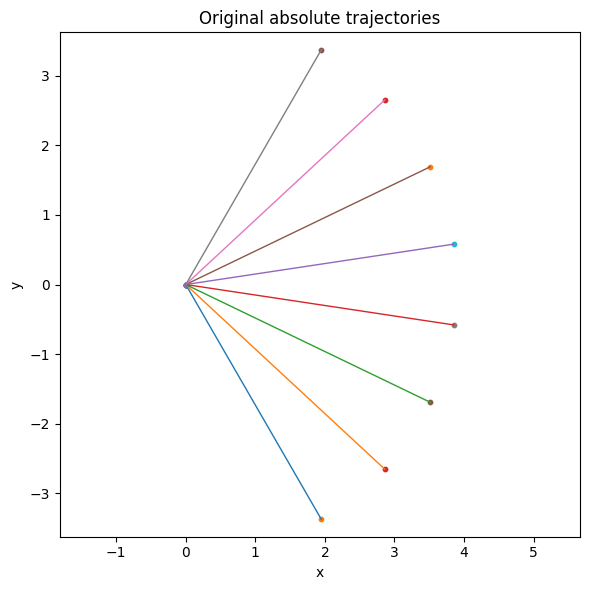

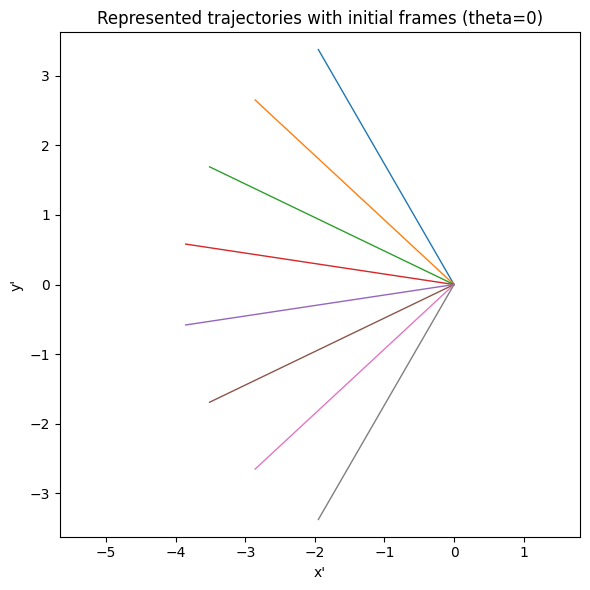

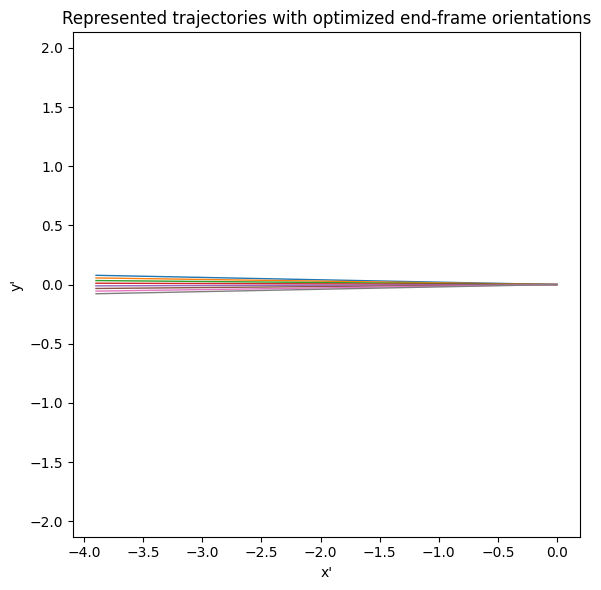

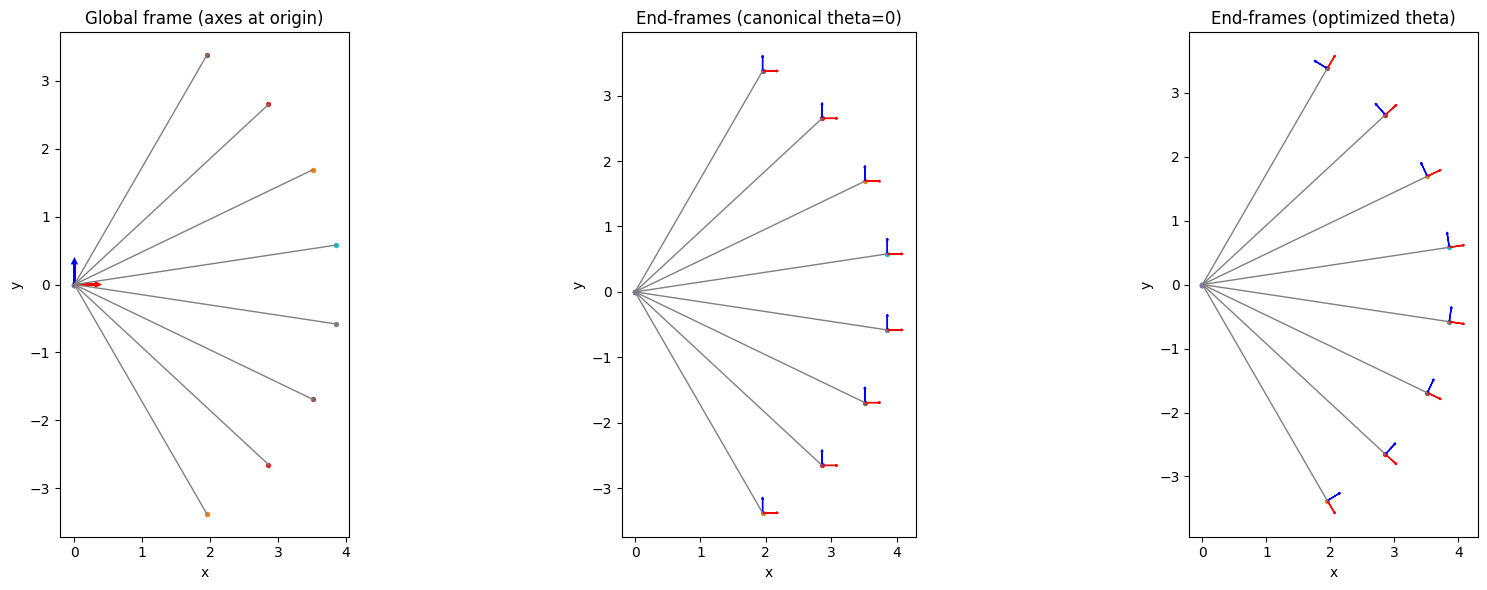

In [5]:
# ------------------ RESULTS & VISUALS ------------------
# 1) Plot original absolute trajectories
plt.figure(figsize=(6, 6))
for i in range(N):
    xs = trajs_np[i, :, 0]
    ys = trajs_np[i, :, 1]
    plt.plot(xs, ys, linewidth=1)
    plt.scatter(xs[0], ys[0], s=10)     # starts
    plt.scatter(xs[-1], ys[-1], s=10)   # ends
plt.axis("equal")
plt.title("Original absolute trajectories")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

# 2) Plot represented trajectories with initial frames (all zero) vs optimized frames
# Initial (zero-theta) representations
with torch.no_grad():
    reps_init = represent_in_end_frame(trajs, torch.zeros_like(thetas)).numpy()
    reps_opt = represent_in_end_frame(trajs, thetas.detach()).numpy()

# Initial frames representation
plt.figure(figsize=(6, 6))
for i in range(N):
    xi = reps_init[i, :, 0]
    yi = reps_init[i, :, 1]
    plt.plot(xi, yi, linewidth=1)
plt.axis("equal")
plt.title("Represented trajectories with initial frames (theta=0)")
plt.xlabel("x'")
plt.ylabel("y'")
plt.tight_layout()
plt.show()

# Optimized frames representation
plt.figure(figsize=(6, 6))
for i in range(N):
    xo = reps_opt[i, :, 0]
    yo = reps_opt[i, :, 1]
    plt.plot(xo, yo, linewidth=1)
plt.axis("equal")
plt.title("Represented trajectories with optimized end-frame orientations")
plt.xlabel("x'")
plt.ylabel("y'")
plt.tight_layout()
plt.show()

# --- ADDED: 3-panel visualization of reference frames ---
def _draw_frame(ax, origin, theta, length=0.4, lw=1.0):
    """
    Draw a 2D reference frame (x in red, y in blue) at origin with orientation theta (radians).
    """
    ox, oy = origin
    cx, sy = math.cos(theta), math.sin(theta)
    # x-axis
    ax.arrow(ox, oy, length * cx, length * sy, head_width=length * 0.12, head_length=length * 0.12, fc='r', ec='r', linewidth=lw, length_includes_head=True)
    # y-axis (rotate +90 deg)
    ax.arrow(ox, oy, -length * sy, length * cx, head_width=length * 0.12, head_length=length * 0.12, fc='b', ec='b', linewidth=lw, length_includes_head=True)

frame_len = step * T * 0.06  # scale frame length relative to trajectory size

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
titles = ["Global frame (axes at origin)",
          "End-frames (canonical theta=0)",
          "End-frames (optimized theta)"]

# Precompute endpoints
endpoints = trajs_np[:, -1, :]  # [N, 2]
opt_thetas = thetas.detach().numpy()

for ax, title in zip(axs, titles):
    # plot trajectories
    for i in range(N):
        xs = trajs_np[i, :, 0]
        ys = trajs_np[i, :, 1]
        ax.plot(xs, ys, linewidth=1, color='gray')
        ax.scatter(xs[0], ys[0], s=8)     # starts
        ax.scatter(xs[-1], ys[-1], s=8)   # ends
    ax.set_aspect('equal', 'box')
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

# Global frame: draw global axes at the origin (single frame)
_draw_frame(axs[0], (0.0, 0.0), 0.0, length=frame_len * 1.5, lw=2.0)

# Canonical end-frames (theta = 0) at each endpoint
for ep in endpoints:
    _draw_frame(axs[1], (ep[0], ep[1]), 0.0, length=frame_len)

# Optimized end-frames at each endpoint with learned theta
for ep, th in zip(endpoints, opt_thetas):
    _draw_frame(axs[2], (ep[0], ep[1]), th, length=frame_len)

plt.tight_layout()
plt.show()

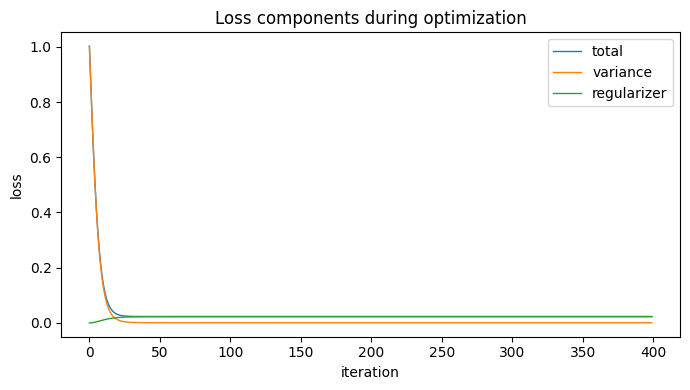

In [6]:
# 3) Loss curves
hist_df = pd.DataFrame(history)
plt.figure(figsize=(7, 4))
plt.plot(hist_df["iter"], hist_df["loss"], linewidth=1, label="total")
plt.plot(hist_df["iter"], hist_df["var"], linewidth=1, label="variance")
plt.plot(hist_df["iter"], hist_df["reg"], linewidth=1, label="regularizer")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("Loss components during optimization")
plt.legend()
plt.tight_layout()
plt.show()
